## **Random Forest**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV

In [2]:
#data_train = pd.read_csv('train_radiomics_hipocamp_mod.csv')
#data_test = pd.read_csv('test_radiomics_hipocamp_mod.csv')

#data_train = pd.read_csv('train_important_features.csv')
#data_test = pd.read_csv('test_important_features.csv')

data_train = pd.read_csv('train_important_features_correlated.csv')
data_test = pd.read_csv('test_important_features_correlated.csv')

In [3]:
# Dividir entre features e target
X = data_train.drop('Transition', axis=1)
y = data_train['Transition']

In [4]:
# Definir o modelo
rf = RandomForestClassifier(class_weight='balanced', random_state=2024)

## Stratified K Fold Cross Validation ##

In [5]:
# Definir StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Cross Validation
scores = cross_validate(rf, X, y, cv=stratified_kfold, scoring='f1_macro')

# Fit do modelo
rf.fit(X, y)

# Acede apenas aos valores do F1-Score Macro
f1_macro_scores = scores['test_score']
print("F1 Macro Scores:", f1_macro_scores)

# Média e desvio padrão do F1 Macro
f1_macro_mean = f1_macro_scores.mean()
f1_macro_std = f1_macro_scores.std()
print(f"Média do F1 Macro: {f1_macro_mean:.4f}")
print(f"Desvio Padrão do F1 Macro: {f1_macro_std:.4f}")

F1 Macro Scores: [0.30311435 0.28616142 0.25871937 0.29777778 0.34123188]
Média do F1 Macro: 0.2974
Desvio Padrão do F1 Macro: 0.0267


In [ ]:
# Prever valores para o dataset de teste
predictions = rf.predict(data_test)

In [5]:
# Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

# Hiperparâmetros para o GridSearch
param_grid = { 
    'n_estimators': [100, 200, 300], 
    'max_features': ['sqrt', 0.2, 0.3], 
    'max_depth': [5, 10, 12], 
    'max_leaf_nodes': [50, 100, None], 
    'min_samples_leaf': [5, 10, 20], 
}

# GridSearch com StratifiedKFold
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)

# Fit do modelo
grid_search.fit(X, y)

# Melhor combinação de hiperparâmetros
print("Melhores parâmetros:", grid_search.best_params_)

# Índice dos melhores parâmetros
best_index = grid_search.best_index_

# Melhor média e desvio padrão do F1-Score
best_mean_f1 = grid_search.cv_results_['mean_test_score'][best_index]
best_std_f1 = grid_search.cv_results_['std_test_score'][best_index]
print(f"Melhor F1-Score (média): {best_mean_f1:.4f}")
print(f"Desvio padrão do F1-Score: {best_std_f1:.4f}")


Melhores parâmetros: {'max_depth': 5, 'max_features': 0.2, 'max_leaf_nodes': None, 'min_samples_leaf': 20, 'n_estimators': 200}
Melhor F1-Score (média): 0.3777
Desvio padrão do F1-Score: 0.0721


In [6]:
# Prever valores para o dataset de teste
predictions = grid_search.best_estimator_.predict(data_test)

In [6]:
# Obter a importância das features
feature_importances = grid_search.best_estimator_.feature_importances_

# Organizar as importâncias em um DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importances_df

,Feature,Importance
191,wavelet-LLH_glszm_SizeZoneNonUniformityNormalized,0.018075
192,wavelet-LLH_glszm_SmallAreaEmphasis,0.016668
1861,lbp-3D-m1_glrlm_ShortRunEmphasis,0.011822
951,log-sigma-2-0-mm-3D_firstorder_InterquartileRange,0.011612
830,wavelet-LLL_glrlm_ShortRunEmphasis,0.011541
...,...,...
973,log-sigma-2-0-mm-3D_glcm_DifferenceVariance,0.000000
972,log-sigma-2-0-mm-3D_glcm_DifferenceEntropy,0.000000
971,log-sigma-2-0-mm-3D_glcm_DifferenceAverage,0.000000
969,log-sigma-2-0-mm-3D_glcm_Contrast,0.000000


In [7]:
# Salvar as features e a suas importâncias num arquivo csv
feature_importances_df.to_csv("feature_importances.csv", index=False)

In [8]:
# Selecionar as features com importância igual a 0
selected_features = feature_importances_df[feature_importances_df['Importance'] == 0]['Feature']
selected_features

1531                    logarithm_glcm_DifferenceVariance
1935                         lbp-3D-k_firstorder_Variance
1445                      squareroot_glcm_InverseVariance
1932                         lbp-3D-k_firstorder_Skewness
1447                          squareroot_glcm_JointEnergy
                              ...                        
973           log-sigma-2-0-mm-3D_glcm_DifferenceVariance
972            log-sigma-2-0-mm-3D_glcm_DifferenceEntropy
971            log-sigma-2-0-mm-3D_glcm_DifferenceAverage
969                     log-sigma-2-0-mm-3D_glcm_Contrast
1006    log-sigma-2-0-mm-3D_glrlm_HighGrayLevelRunEmph...
Name: Feature, Length: 880, dtype: object

In [9]:
# Remover as features com importância igual a 0
train_important_features = data_train.drop(selected_features, axis=1)
test_important_features = data_test.drop(selected_features, axis=1)

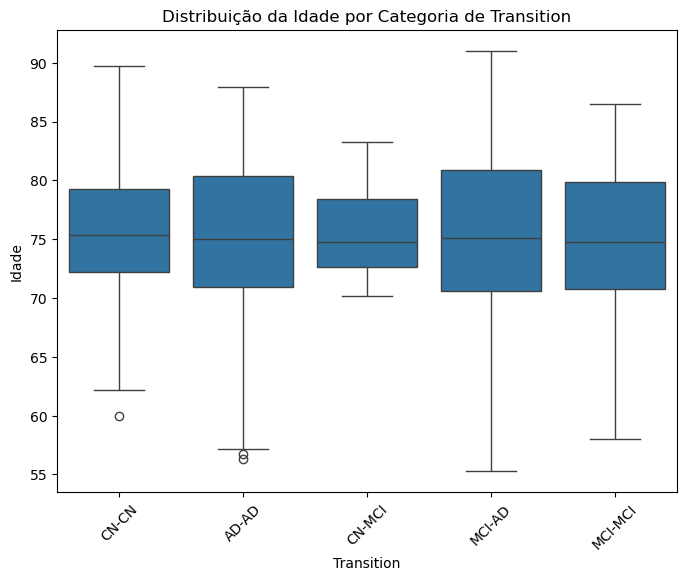

In [11]:
# Criar o boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Transition', y='Age', data=data_train)
plt.title('Distribuição da Idade por Categoria de Transition')
plt.xlabel('Transition')
plt.ylabel('Idade')
plt.xticks(rotation=45)
plt.show()

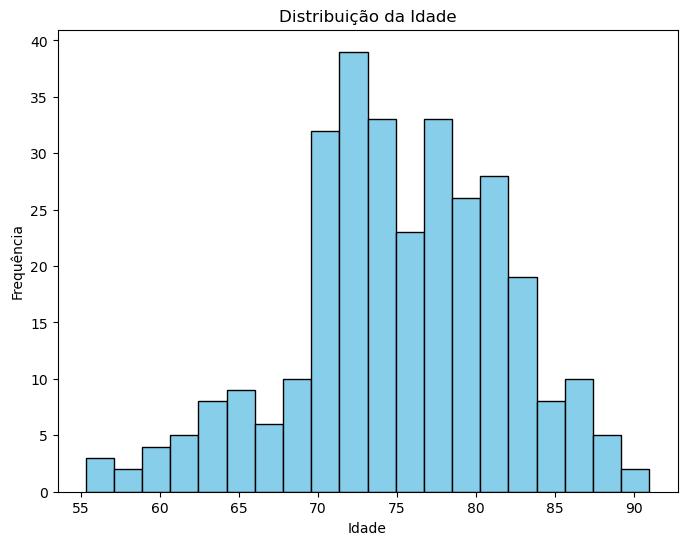

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(data_train['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuição da Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.show()

In [10]:
# Salvar os datasets com as features importantes
train_important_features.to_csv("train_important_features.csv", index=False)
test_important_features.to_csv("test_important_features.csv", index=False)

In [11]:
# Salvar as previsões num ficheiro csv
output = pd.DataFrame({'RowId': data_test.index + 1, 'Result': predictions})
output.to_csv('Subs/rf_test_predictions.csv', index=False)

NameError: name 'predictions' is not defined